In [175]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [176]:
import sys
sys.path.append('../')
import utils

In [177]:
train_a, train_b, train_c, X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c = utils.read_files(diff_path='../')


## Etude du signal de notre sortie :

In [178]:
from scipy.fft import fft, ifft
from scipy.signal import find_peaks

In [179]:
#le signal :
signal_a = train_a

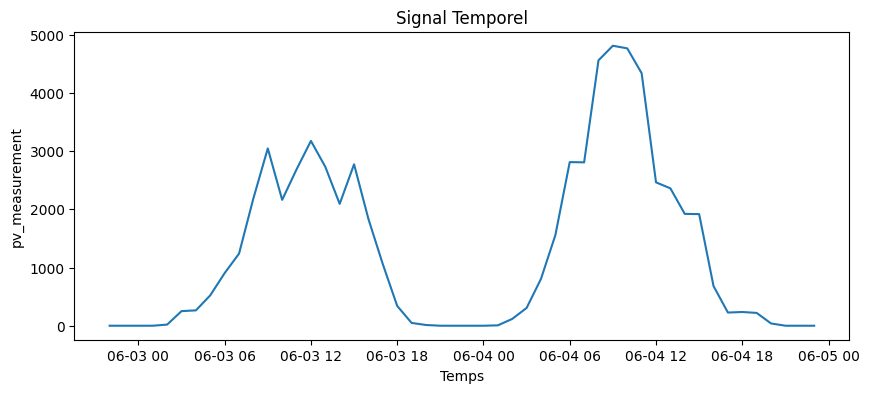

In [180]:
# Affichez le signal temporel
plt.figure(figsize=(10, 4))
plt.plot(signal_a["time"][:50], signal_a["pv_measurement"][:50])
plt.title("Signal Temporel")
plt.xlabel("Temps")
plt.ylabel("pv_measurement")
plt.show()

In [181]:
# Analyse de la fréquence du signal
signal = signal_a["pv_measurement"].values
time_diff = 1 #signal_a["time"].diff().mean().total_seconds()  # Obtenez la durée moyenne entre deux échantillons en secondes
sampling_rate = 1 / time_diff  # Taux d'échantillonnage en Hz / h-1 = 1/3600 Hz

n = len(signal)
frequencies = np.fft.fftfreq(n, 1 / sampling_rate)
fft_values = fft(signal)
amplitudes = np.abs(fft_values)
phases = np.angle(fft_values)

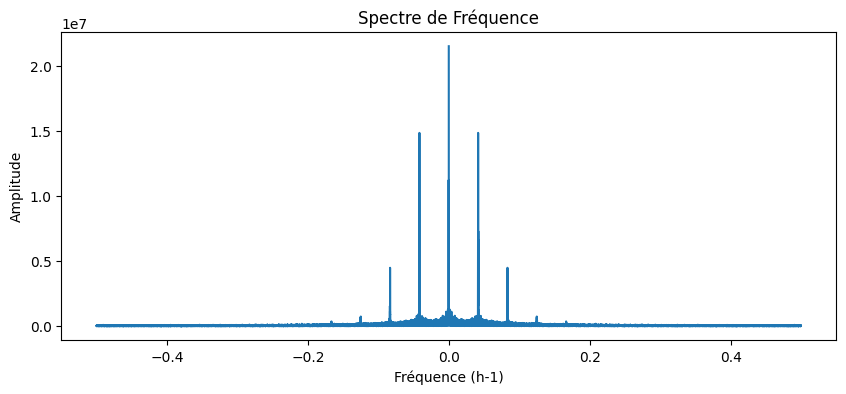

In [182]:
# Affichez le spectre de fréquence
plt.figure(figsize=(10, 4))
plt.plot(frequencies, amplitudes)
plt.title("Spectre de Fréquence")
plt.xlabel("Fréquence (h-1)")
plt.ylabel("Amplitude")
# plt.xlim(-10**-4, 10**-4)  # Limitez l'affichage des fréquences
plt.show()

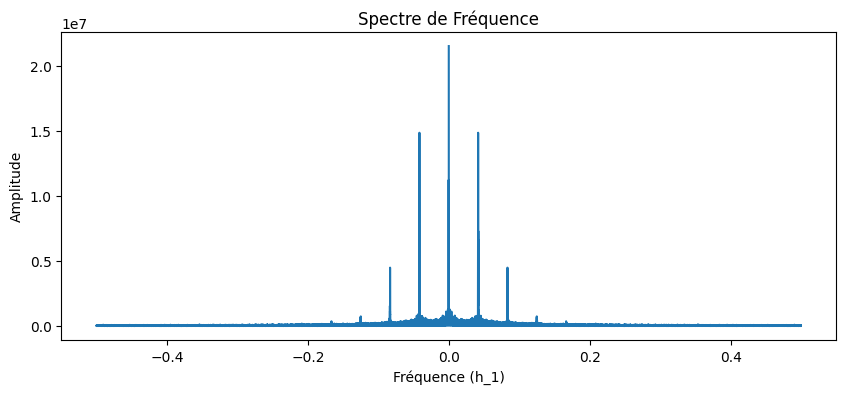

In [183]:
# Zoom le spectre de fréquence
plt.figure(figsize=(10, 4))
plt.plot(frequencies, amplitudes)
plt.title("Spectre de Fréquence")
plt.xlabel("Fréquence (h_1)")
plt.ylabel("Amplitude")
# plt.xlim(1e-05, 1.2*10**-5)  # Limitez l'affichage des fréquences
plt.show()

In [184]:
# Identifier les pics dans le spectre de fréquence
threshold = 0.2 * 10**7
peaks, _ = find_peaks(amplitudes[:len(amplitudes)//2], height=threshold)
peak_frequencies = frequencies[:len(frequencies)//2][peaks]

# calcul de la composante continue
longueur_periode = int(1/peak_frequencies[0])
composante_continue = np.mean(signal[:longueur_periode])

print(peak_frequencies)
print(composante_continue)

[0.00011735 0.0415432  0.04166055 0.04177791 0.08332111]
584.6874111019833


On obtient différentes pics.

Le pic à 0 correspond à la composante continue. (ici il n'y en a pas)

Le pic à 3.24184785e-08 correspond à la variation tt les ans

Le triple pic à 1.15085599e-05 correspond aux variations tt les 24h

Le pic à 2.30171197e-05 correspond au variations tt les 12h


In [185]:
sampling_rate

1.0

/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/arthurtestard/envs/ntnu/mlsolar/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


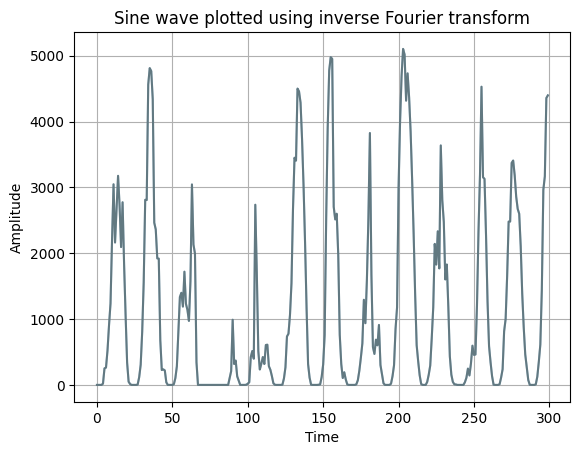

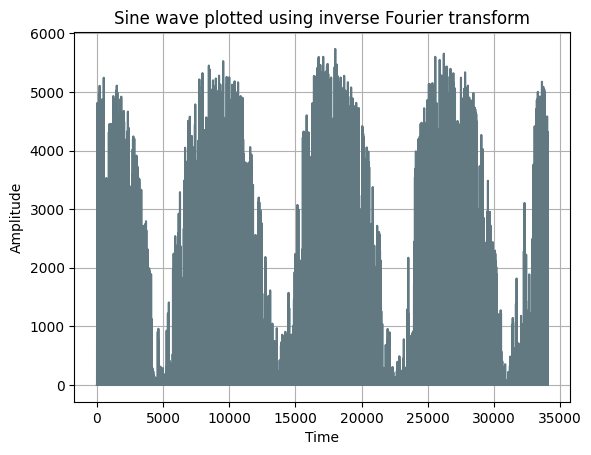

In [186]:
# reconstruction signal entier
reconstruit = np.fft.ifft(fft_values)

# Plot the original sine wave using inverse Fourier transform

plt.plot(signal[:300])
plt.plot(reconstruit[:300],alpha=0.3)
plt.title("Sine wave plotted using inverse Fourier transform");
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

plt.plot(signal)
plt.plot(reconstruit,alpha=0.3)
plt.title("Sine wave plotted using inverse Fourier transform");
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

In [187]:
# reconstruction avec filtre :
def filtrage(fft_values, threshold = 0.7*10**6):
  compteur = 0
  fft_filtre = []
  for fft_value in fft_values:
    if threshold < np.abs(fft_value) :
      fft_filtre.append(fft_value)
      compteur +=1
    else : fft_filtre.append(0)
  # print(fft_filtre)
  reconstruit_filtré = np.fft.ifft(fft_filtre)
  # print(len(fft_filtre), sum([np.abs(fft_filtr) > 0 for fft_filtr in fft_filtre]), compteur)
  return reconstruit_filtré, compteur


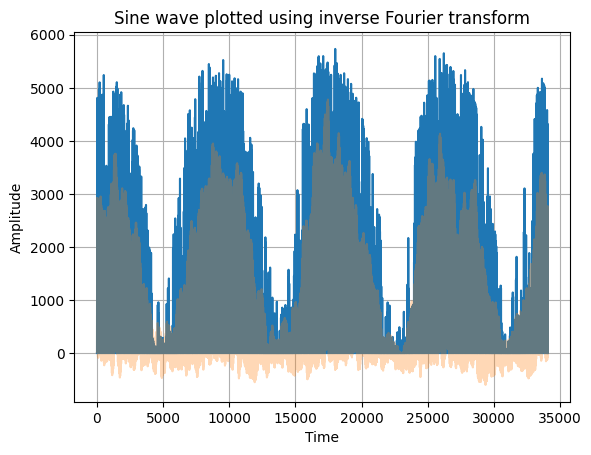

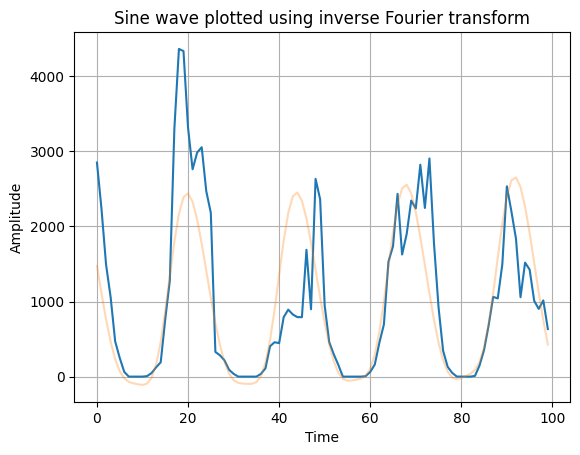

In [188]:
reconstruit_filtré, compteur = filtrage(fft_values)

plt.plot(signal)
plt.plot(reconstruit_filtré,alpha=0.3)
plt.title("Sine wave plotted using inverse Fourier transform")
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

plt.plot(signal[400:500])
plt.plot(reconstruit_filtré[400:500],alpha=0.3)
plt.title("Sine wave plotted using inverse Fourier transform");
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

In [189]:
def calcul_ecart(signal, filtre):
  ecart = np.real(reconstruit_filtré - signal)
  return ecart

In [190]:
liste_threshold = np.linspace(0.1 * 10**5, 0.1 * 10**8, 300)
liste_compteur = []
liste_ecart = []

for threshold in liste_threshold :
  reconstruit_filtré, compteur = filtrage(fft_values,threshold)
  liste_compteur.append(compteur)
  ecart = calcul_ecart(signal,reconstruit_filtré)
  liste_ecart.append(abs(ecart).sum()/len(ecart))

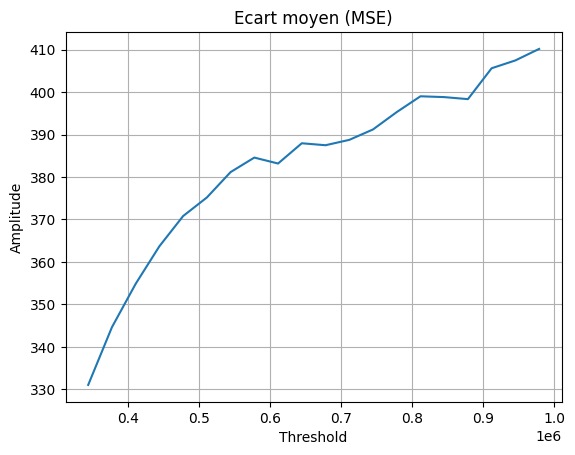

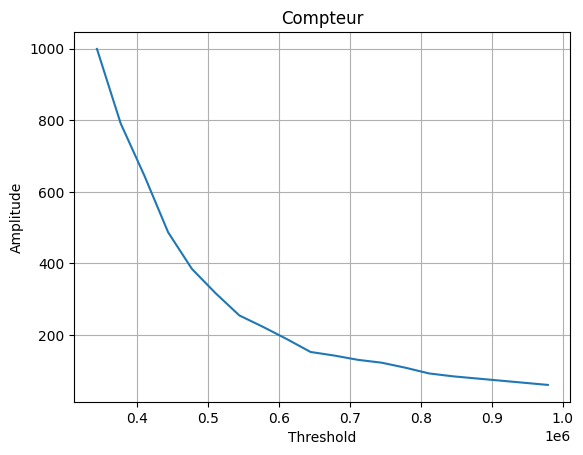

In [191]:
plt.plot(liste_threshold[10:30],liste_ecart[10:30])
plt.title("Ecart moyen (MSE)")
plt.xlabel('Threshold')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

plt.plot(liste_threshold[10:30],liste_compteur[10:30])
plt.title("Compteur")
plt.xlabel('Threshold')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

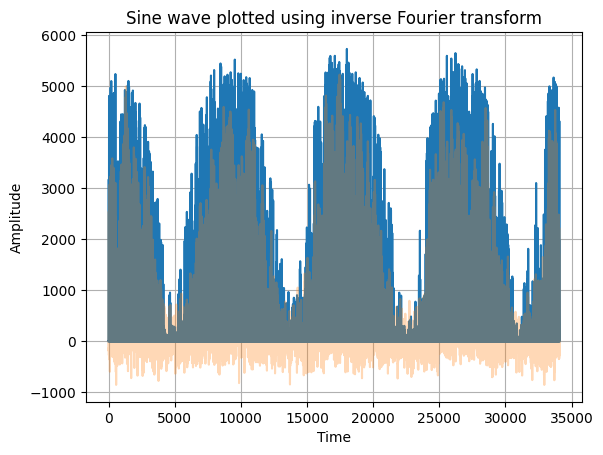

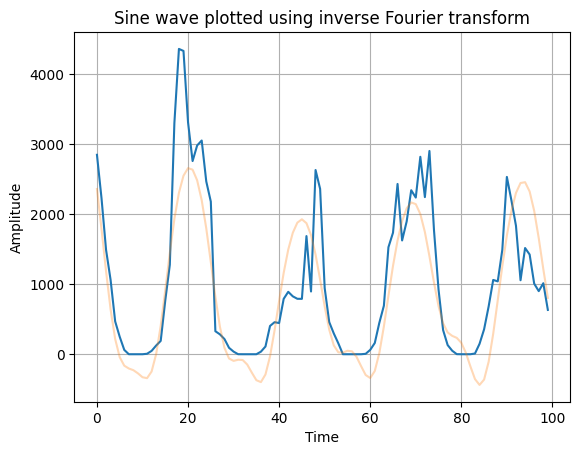

In [192]:
reconstruit_filtré, compteur= filtrage(fft_values,threshold=0.4 * 10**6)

plt.plot(signal)
plt.plot(reconstruit_filtré,alpha=0.3)
plt.title("Sine wave plotted using inverse Fourier transform")
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

plt.plot(signal[400:500])
plt.plot(reconstruit_filtré[400:500],alpha=0.3)
plt.title("Sine wave plotted using inverse Fourier transform")
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

### Récupération du model après FFT

In [193]:
signal = signal_a["pv_measurement"].values
time_diff = 1 # signal_a["time"].diff().mean().total_seconds()  # Obtenez la durée moyenne entre deux échantillons en secondes
sampling_rate = 1 / time_diff  # Taux d'échantillonnage en Hz

sampling_rate # h-1 ou 1 / 3600 Hz

1.0

In [194]:
def recuperation_model(fft_values, threshold=0.4 * 10**6):

      sample_rate = sampling_rate
      n = len(fft_values)
      frequencies = np.fft.fftfreq(n, 1 / sample_rate)

      # Filtrage et calcul des amplitudes
      amplitudes = fft_values * (np.abs(fft_values) > threshold)

      # Obtenez les phases des valeurs FFT
      phases = np.angle(fft_values)

      return frequencies, amplitudes, phases
      # Te est le même pour tous !


In [195]:
frequencies, amplitudes, phases = recuperation_model(fft_values)
model = {"frequencies" : frequencies,
         "amplitudes" : amplitudes,
         "phases" : phases}

In [196]:
frequencies.shape, amplitudes.shape, phases.shape

((34085,), (34085,), (34085,))

In [197]:
frequencies

array([ 0.00000000e+00,  2.93384187e-05,  5.86768373e-05, ...,
       -8.80152560e-05, -5.86768373e-05, -2.93384187e-05])

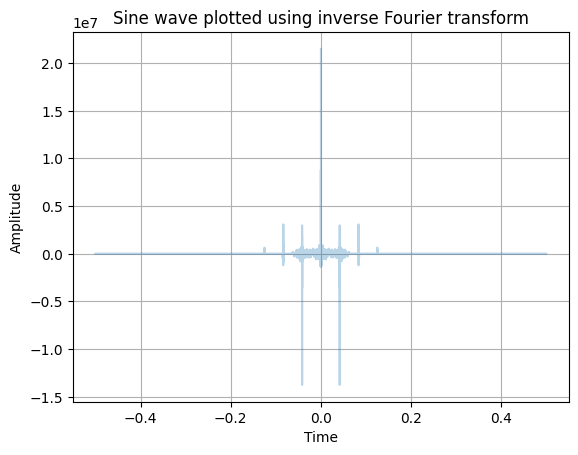

In [198]:
plt.plot(model["frequencies"], model["amplitudes"], alpha=0.3)
plt.title("Sine wave plotted using inverse Fourier transform")
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

In [203]:
def prediction_TS(model, debut, fin):
    frequencies = model["frequencies"]
    amplitudes = model["amplitudes"]
    phases = model["phases"]

    Te = 1 # 3619.962445 # à définir (normalement c'est une heure)
    resultat = []
    for i in range(debut, fin):
        aux = 0
        for i_freq in range(len(frequencies)):
          # if amplitudes[i_freq] > 0:
          aux += amplitudes[i_freq] * np.exp(2 * np.pi * frequencies[i_freq] * i * Te * 1j) / Te
        resultat.append(np.real(aux))
    print(len(resultat))
    return resultat

In [204]:
resultat = prediction_TS(model,0, 300)

300


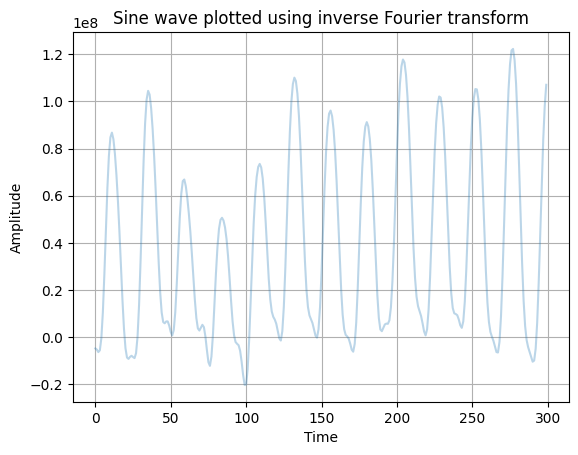

In [205]:
plt.plot(resultat, alpha=0.3)
plt.title("Sine wave plotted using inverse Fourier transform")
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

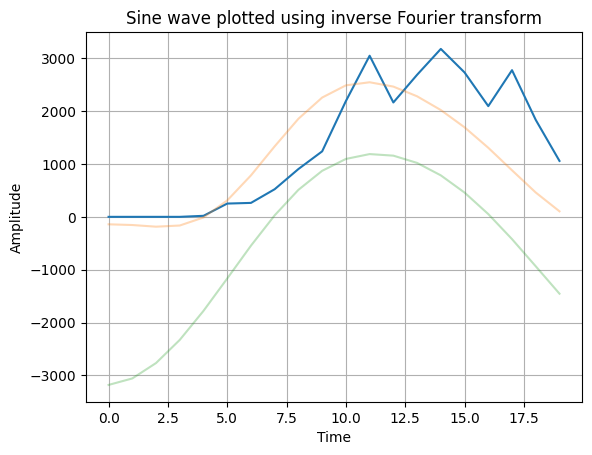

In [202]:
plt.plot(signal[:20])
plt.plot(reconstruit_filtré[:20],alpha=0.3)
plt.plot(np.array(resultat[:20]) / 1e9 * 3000,alpha=0.3)
plt.title("Sine wave plotted using inverse Fourier transform")
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()